<a href="https://colab.research.google.com/github/Manjunath727/DLwithTF/blob/master/CNN_Using_TF/W3/TransferLearningWithDropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Cats and Dogs

## Pre Trained model

Here we download the pre-trained model's weights

In [5]:
from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(150,150,3),
    include_top=False,
    weights=None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2019-07-16 12:07:04--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  77.5MB/s    in 1.1s    

2019-07-16 12:07:11 (77.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



W0716 12:07:11.697542 140654919296896 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Adding a DNN

In [6]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['acc'])

W0716 12:07:22.681071 140654919296896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Download the data

This step we download the data and create datagenerators

In [7]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip


--2019-07-16 12:07:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  86.7MB/s    in 0.8s    

2019-07-16 12:07:24 (86.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

with zipfile.ZipFile(local_zip) as zip_ref:
  zip_ref.extractall('/tmp')
  zip_ref.close()

In [0]:
# Define example directories

base_dir = '/tmp/cats_and_dogs_filtered/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
validation_cats_dir = os.path.join(validation_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)


In [10]:
# Create Datagenerators 
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# Note validation data should not be augmented 
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Flow training images in a batch of 20 using train_datagen
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    class_mode = 'binary',
                                                    target_size = (150,150))

# Flow validation images in a batch of 20 using test_datagen
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size = 64,
                                                        class_mode = 'binary',
                                                        target_size = (150,150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Train the model

In [11]:
history = model.fit_generator(
          train_generator,
          validation_data = validation_generator,
          steps_per_epoch = 100,
          epochs = 20,
          validation_steps = 50,
          verbose = 2)

Epoch 1/20
100/100 - 523s - loss: 0.4641 - acc: 0.7884 - val_loss: 0.1928 - val_acc: 0.9425
Epoch 2/20
100/100 - 515s - loss: 0.3031 - acc: 0.8648 - val_loss: 0.3225 - val_acc: 0.9293
Epoch 3/20
100/100 - 515s - loss: 0.2767 - acc: 0.8824 - val_loss: 0.3338 - val_acc: 0.9348
Epoch 4/20
100/100 - 513s - loss: 0.2454 - acc: 0.8958 - val_loss: 0.4363 - val_acc: 0.9332
Epoch 5/20
100/100 - 518s - loss: 0.2340 - acc: 0.8978 - val_loss: 0.5034 - val_acc: 0.9265
Epoch 6/20
100/100 - 511s - loss: 0.2251 - acc: 0.9045 - val_loss: 0.4821 - val_acc: 0.9341
Epoch 7/20
100/100 - 514s - loss: 0.2167 - acc: 0.9102 - val_loss: 0.5340 - val_acc: 0.9338
Epoch 8/20
100/100 - 518s - loss: 0.2084 - acc: 0.9146 - val_loss: 0.4044 - val_acc: 0.9517
Epoch 9/20
100/100 - 515s - loss: 0.2089 - acc: 0.9193 - val_loss: 0.7031 - val_acc: 0.9325
Epoch 10/20
100/100 - 516s - loss: 0.1977 - acc: 0.9230 - val_loss: 0.5510 - val_acc: 0.9399
Epoch 11/20
100/100 - 515s - loss: 0.1918 - acc: 0.9254 - val_loss: 0.3859 - va

## Plot the accuracy curve

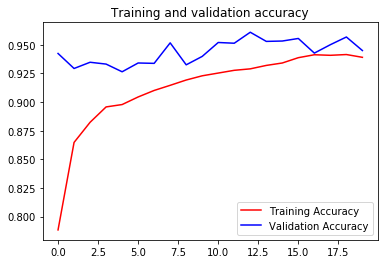

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()